In [30]:
import cv2
import torch
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from albumentations.pytorch import ToTensorV2
from Training.configurations import MODEL_NAME
from Training.tablenet_model import TableNet
from Training.path_constants import PREDICTIONS, MODELS, TEST_IMAGES

In [31]:
TRANSFORM = A.Compose([
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value = 255,
    ),
    ToTensorV2()
])

In [32]:
def display_prediction(img, table = None, table_image = None, no_: bool = False):
  if no_:
    f1, ax  = plt.subplots(1, 1, figsize = (7, 5))
    ax.imshow(img)
    ax.set_title('Original Image')
    f1.suptitle('No Tables Detected')
  else:
    f2, ax  = plt.subplots(1, 3, figsize = (15, 8))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(table)
    ax[1].set_title('Image with Predicted Table')
    ax[2].imshow(table_image)
    ax[2].set_title('Predicted Table Example')
  plt.show()

In [61]:
model_path = f"{MODELS}/{MODEL_NAME}"
print(model_path)
model = TableNet(encoder = 'vgg', use_pretrained_model = True, basemodel_requires_grad = True)
model.eval()
# Load checkpoint
if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_path)['state_dict'])
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['state_dict'])

./DummyDatabase/models/densenet_configuration_4_model_checkpoint.pth.tar


/Users/somoysu/anaconda3/envs/tablenet/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/somoysu/anaconda3/envs/tablenet/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
# Final prediction function, using the mask fixing method too
def predict(img_path):
    orig_image = Image.open(img_path).resize((1024, 1024))
    test_img = np.array(orig_image.convert('LA').convert("RGB"))
    now = datetime.now()
    image = TRANSFORM(image = test_img)["image"]
    with torch.no_grad():
        image = image.unsqueeze(0)
        table_out, _  = model(image)
        table_out = torch.sigmoid(table_out)
    # Remove gradients
    table_out = (table_out.detach().numpy().squeeze(0).transpose(1, 2, 0) > 0.5).astype(np.uint8)
    # Get contours of the mask to get number of tables
    contours, table_heirarchy = cv2.findContours(table_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    table_contours = []
    # Ref: https://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/
    # Remove bad contours
    for c in contours:
        if cv2.contourArea(c) > 6000:
            table_contours.append(c)
    if len(table_contours) == 0:
        print("No Table detected")
    table_boundRect = [None] * len(table_contours)
    for i, c in enumerate(table_contours):
        polygon = cv2.approxPolyDP(c, 3, True)
        table_boundRect[i] = cv2.boundingRect(polygon)
    # Table bounding Box
    table_boundRect.sort()
    orig_image = np.array(orig_image)
    # Draw bounding boxes
    color = (0, 0, 255)
    thickness = 4
    for x,y,w,h in table_boundRect:
        cv2.rectangle(orig_image, (x , y), (x + w, y + h), color, thickness)
    # Show Original image with the table bordered extra
    plt.figure(figsize = (10, 5))
    plt.imshow(orig_image)
    end_time = datetime.now()
    difference = end_time - now
    time = "{}".format(difference)
    print(f"Time Taken on cpu: {time} secs")
    print("Predicted Tables")
    image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)
    for i, (x, y, w, h) in enumerate(table_boundRect):
        image_crop = image[y : y + h, x : x + w]
        # Show only the table
        plt.figure(figsize = (7.5, 5))
        plt.imshow(image_crop)
        cv2.imwrite(f"/{PREDICTIONS}/image_crop.png", image_crop)
        data = pytesseract.image_to_string(image_crop)

In [63]:
from PIL import Image

def resize_content_with_background(image_path, scale_factor):
    # Open the image using Pillow
    img = Image.open(image_path)

    # Get the original image dimensions
    width, height = img.size

    # Calculate the new dimensions based on the scale factor
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)

    # Resize the image while maintaining the aspect ratio
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create a new white background image with the original dimensions
    background = Image.new('RGB', (width, height), 'white')

    # Calculate the position to paste the resized image in the center
    x = int((width - new_width) / 2)
    y = int((height - new_height) / 2)

    # Paste the resized image onto the white background
    background.paste(resized_img, (x, y))

    # Save the modified image
    background.save(f'{TEST_IMAGES}/resized/resized_image.jpg')

# Usage example
_image_path = f'{TEST_IMAGES}/one.jpg'
resize_content_with_background(_image_path, 0.75)

./DummyDatabase/test_images/resized/resized_image.jpg
Time Taken on cpu: 0:00:02.945289 secs
Predicted Tables
None


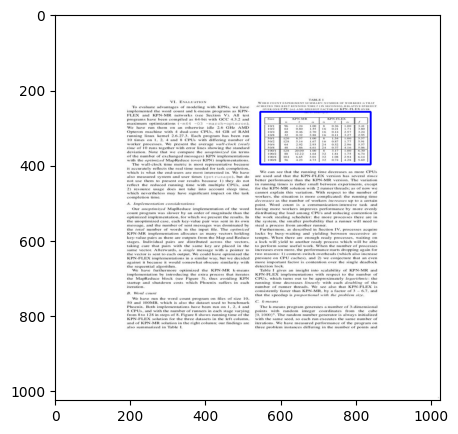

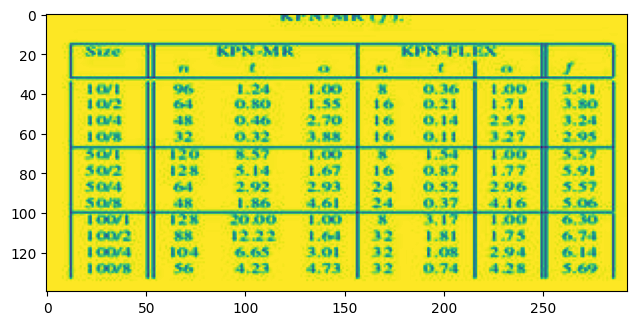

In [64]:
_image_path = f'{TEST_IMAGES}/resized/resized_image.jpg'
# _image_path = f'{TEST_IMAGES}/hand_drawn.jpg'
print(_image_path)
df = predict(img_path = _image_path)
print(df)

**Testing Against ICDAR 2019 - Table Detection Dataset**

In [65]:
import os
icdar_path = f'{TEST_IMAGES}/ICDAR'

# Function to find all XML files within a directory
def find_xml_files(directory):
    xml_list = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.xml'):
                xml_list.append(os.path.join(root, file))
    return xml_list

# List all XML files
all_xml_files = find_xml_files(icdar_path)
print(all_xml_files)

['./DummyDatabase/test_images/ICDAR/4_152.xml', './DummyDatabase/test_images/ICDAR/3_60.xml', './DummyDatabase/test_images/ICDAR/3_107.xml', './DummyDatabase/test_images/ICDAR/6_93.xml', './DummyDatabase/test_images/ICDAR/2_20.xml', './DummyDatabase/test_images/ICDAR/2_36.xml', './DummyDatabase/test_images/ICDAR/8_57.xml', './DummyDatabase/test_images/ICDAR/2_100.xml', './DummyDatabase/test_images/ICDAR/7_285.xml', './DummyDatabase/test_images/ICDAR/7_246.xml', './DummyDatabase/test_images/ICDAR/5_10.xml', './DummyDatabase/test_images/ICDAR/6_26.xml', './DummyDatabase/test_images/ICDAR/6_236.xml', './DummyDatabase/test_images/ICDAR/2_161.xml', './DummyDatabase/test_images/ICDAR/6_33.xml', './DummyDatabase/test_images/ICDAR/2_57.xml', './DummyDatabase/test_images/ICDAR/1_301.xml', './DummyDatabase/test_images/ICDAR/4_34.xml', './DummyDatabase/test_images/ICDAR/4_127.xml', './DummyDatabase/test_images/ICDAR/4_21.xml', './DummyDatabase/test_images/ICDAR/6_18.xml', './DummyDatabase/test_im

In [66]:
import xml.etree.ElementTree as ET

all_bbox_dict = {}

for xml_path in all_xml_files:
    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extract bounding boxes for objects
    bboxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append((name, xmin, ymin, xmax, ymax))
    
    all_bbox_dict[os.path.basename(xml_path)] = bboxes

all_bbox_dict

{'4_152.xml': [('table', 33, 69, 539, 257), ('table', 32, 570, 539, 703)],
 '3_60.xml': [('table', 47, 143, 412, 345), ('table', 47, 383, 412, 615)],
 '3_107.xml': [('table', 54, 331, 418, 611), ('table', 54, 32, 418, 292)],
 '6_93.xml': [('table', 80, 31, 503, 557), ('table', 80, 593, 503, 691)],
 '2_20.xml': [('table', 13, 423, 559, 728)],
 '2_36.xml': [('table', 13, 514, 559, 664), ('table', 13, 64, 558, 352)],
 '8_57.xml': [('table', 52, 118, 449, 368)],
 '2_100.xml': [('table', 13, 115, 558, 218),
  ('table', 13, 531, 559, 597),
  ('table', 13, 629, 558, 682)],
 '7_285.xml': [('table', 98, 199, 473, 764)],
 '7_246.xml': [('table', 61, 89, 558, 197)],
 '5_10.xml': [('table', 85, 142, 614, 240), ('table', 85, 303, 614, 378)],
 '6_26.xml': [('table', 12, 386, 568, 520)],
 '6_236.xml': [('table', 21, 521, 565, 704)],
 '2_161.xml': [('table', 13, 619, 558, 858), ('table', 85, 47, 390, 230)],
 '6_33.xml': [('table', 49, 583, 508, 658), ('table', 11, 31, 560, 250)],
 '2_57.xml': [('table

In [67]:
import pandas as pd

# Convert the dictionary to a DataFrame
rows = []
for xml_filename, bboxes in all_bbox_dict.items():
    for bbox in bboxes:
        label, xmin_orig, ymin_orig, xmax_orig, ymax_orig = bbox
        filename = xml_filename.replace('.xml', '')
        rows.append([filename, xmin_orig, ymin_orig, xmax_orig, ymax_orig])

df = pd.DataFrame(rows, columns=['Filename', 'xmin_orig', 'ymin_orig', 'xmax_orig', 'ymax_orig'])

df.head() 

Filename  xmin_orig  ymin_orig  xmax_orig  ymax_orig
0    4_152         33         69        539        257
1    4_152         32        570        539        703
2     3_60         47        143        412        345
3     3_60         47        383        412        615
4    3_107         54        331        418        611

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   50 non-null     object
 1   xmin_orig  50 non-null     int64 
 2   ymin_orig  50 non-null     int64 
 3   xmax_orig  50 non-null     int64 
 4   ymax_orig  50 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.1+ KB


In [69]:
def getPredictedBoundingBoxes(image_path):
    orig_image = Image.open(image_path).resize((1024, 1024))
    test_img = np.array(orig_image.convert('LA').convert("RGB"))
    image = TRANSFORM(image = test_img)["image"]
    with torch.no_grad():
        image = image.unsqueeze(0)
        table_out, _  = model(image)
        table_out = torch.sigmoid(table_out)
    table_out = (table_out.detach().numpy().squeeze(0).transpose(1, 2, 0) > 0.5).astype(np.uint8)
    contours, table_heirarchy = cv2.findContours(table_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    table_contours = []
    # Remove bad contours
    for c in contours:
        if cv2.contourArea(c) > 5000:
            table_contours.append(c)
    if len(table_contours) == 0:
        return "No Table detected"
    table_boundRect = [None] * len(table_contours)
    for i, c in enumerate(table_contours):
        polygon = cv2.approxPolyDP(c, 3, True)
        table_boundRect[i] = cv2.boundingRect(polygon)
    # Table bounding Box
    table_boundRect.sort()
    bboxes = []
    for x,y,w,h in table_boundRect:
        xmin = x
        ymin = y
        xmax = x + w
        ymax = y + h
        bboxes.append((xmin, ymin, xmax, ymax))
    return bboxes

Time Taken on cpu: 0:00:02.025511 secs
Predicted Tables
Time Taken on cpu: 0:00:02.047848 secs
Predicted Tables
Time Taken on cpu: 0:00:01.930948 secs
Predicted Tables
Time Taken on cpu: 0:00:02.075214 secs
Predicted Tables
Time Taken on cpu: 0:00:02.326768 secs
Predicted Tables
Time Taken on cpu: 0:00:02.271278 secs
Predicted Tables


/var/folders/cv/8q8h6_rj1xd3tr3bk5_6fnh80000gn/T/ipykernel_20584/2896645862.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 5))


Time Taken on cpu: 0:00:02.110234 secs
Predicted Tables
Time Taken on cpu: 0:00:02.066185 secs
Predicted Tables
Time Taken on cpu: 0:00:02.053459 secs
Predicted Tables
Time Taken on cpu: 0:00:02.173058 secs
Predicted Tables
Time Taken on cpu: 0:00:02.547180 secs
Predicted Tables
Time Taken on cpu: 0:00:02.157921 secs
Predicted Tables
Time Taken on cpu: 0:00:02.149276 secs
Predicted Tables
Time Taken on cpu: 0:00:02.041982 secs
Predicted Tables
Time Taken on cpu: 0:00:02.046204 secs
Predicted Tables
Time Taken on cpu: 0:00:02.058628 secs
Predicted Tables
Time Taken on cpu: 0:00:02.123645 secs
Predicted Tables
Time Taken on cpu: 0:00:02.433886 secs
Predicted Tables
Time Taken on cpu: 0:00:02.651729 secs
Predicted Tables
Time Taken on cpu: 0:00:02.726985 secs
Predicted Tables
Time Taken on cpu: 0:00:02.545534 secs
Predicted Tables
Time Taken on cpu: 0:00:02.536134 secs
Predicted Tables
Time Taken on cpu: 0:00:02.974225 secs
Predicted Tables
Time Taken on cpu: 0:00:02.724855 secs
Predicted

Filename  height_orig  width_orig  xmin_pred  ymin_pred  xmax_pred  \
0    4_152          576         912         50         42        960   
1    4_152          576         912         56        640        960   
2     3_60          469         627         96        224        896   
3     3_60          469         627         96        591        896   
4    3_107          469         627        115         48        915   

   ymax_pred  
0        352  
1        800  
2        576  
3       1003  
4        496

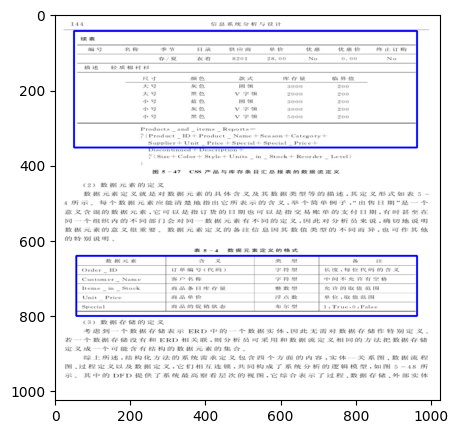

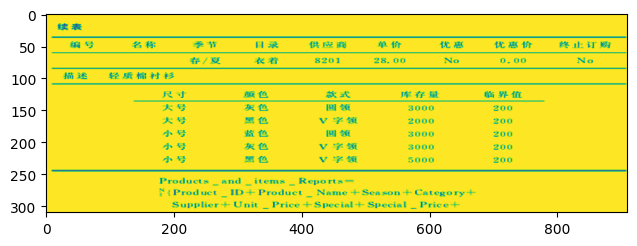

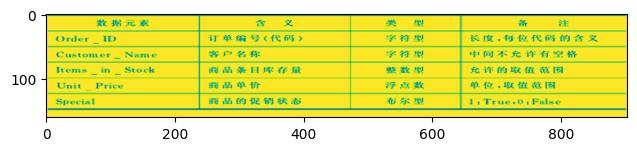

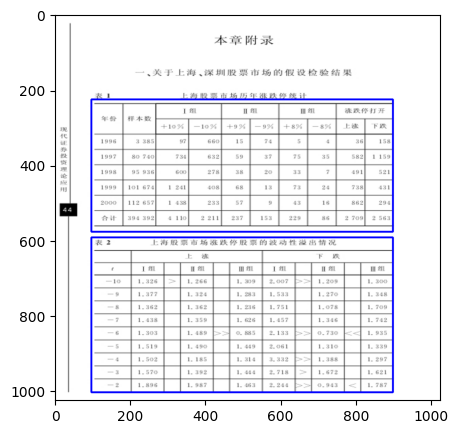

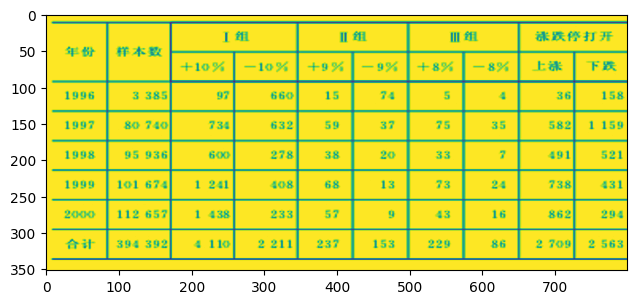

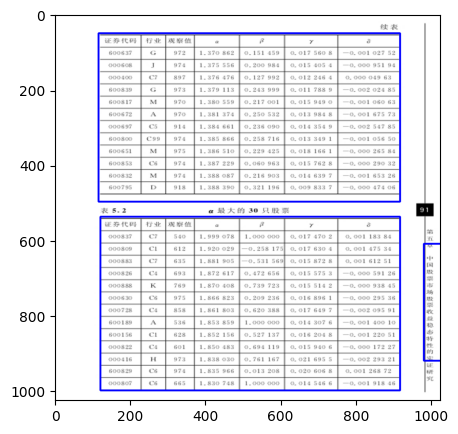

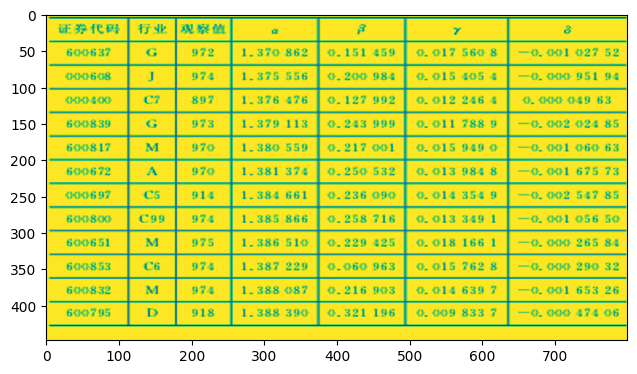

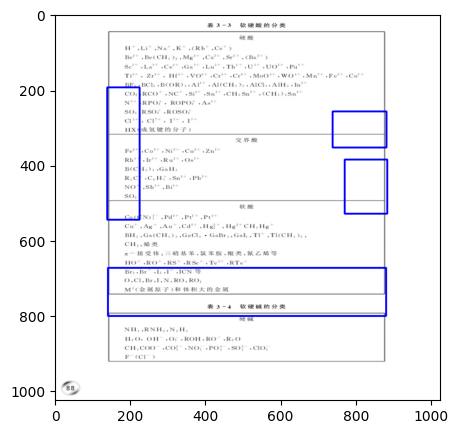

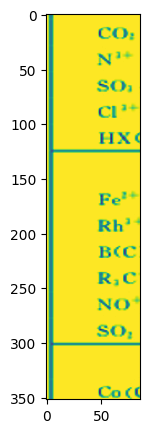

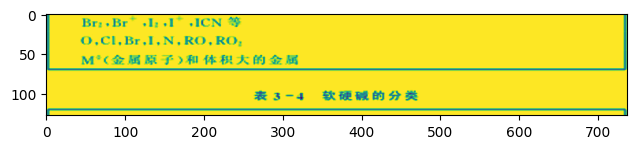

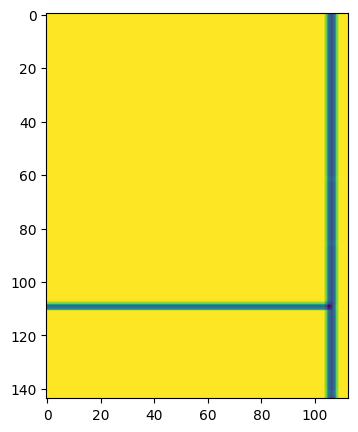

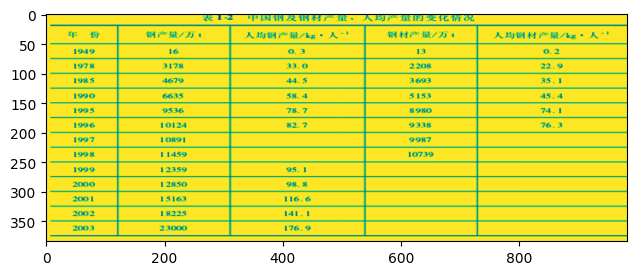

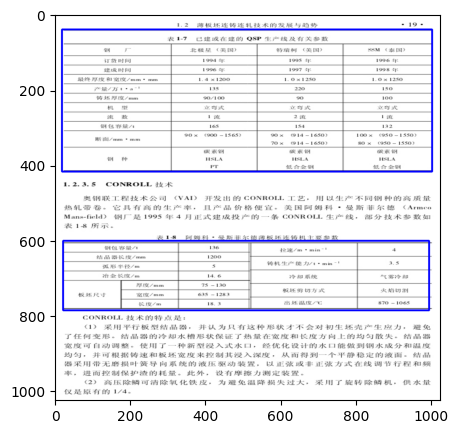

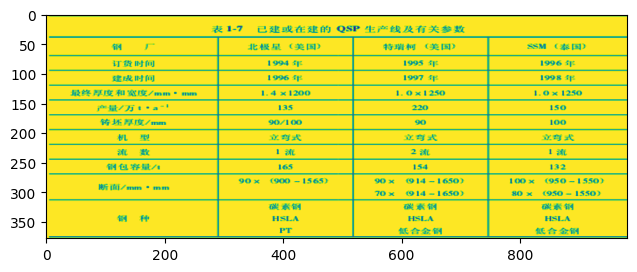

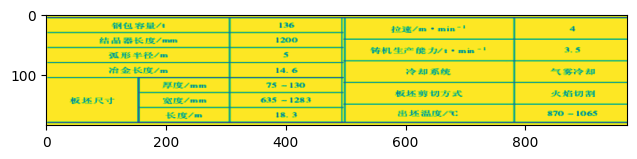

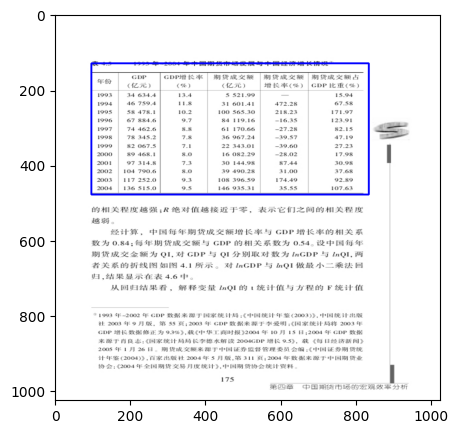

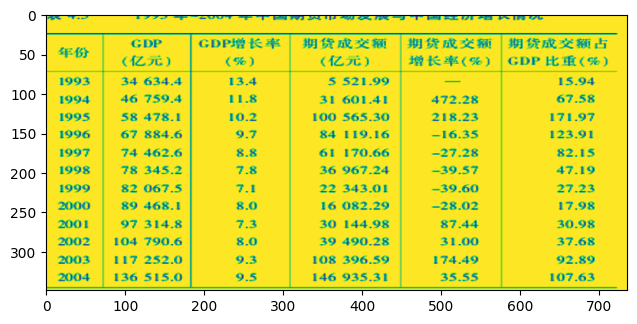

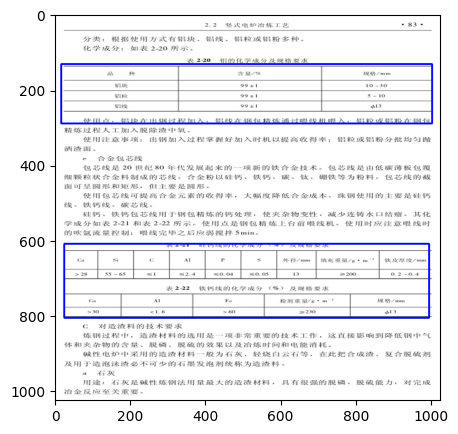

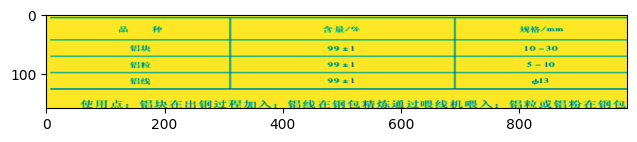

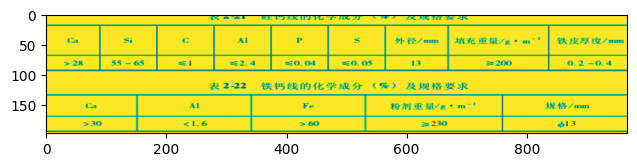

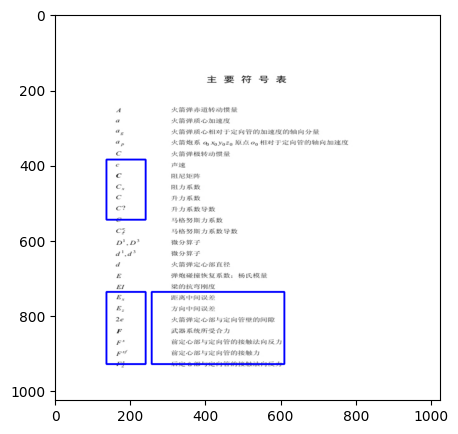

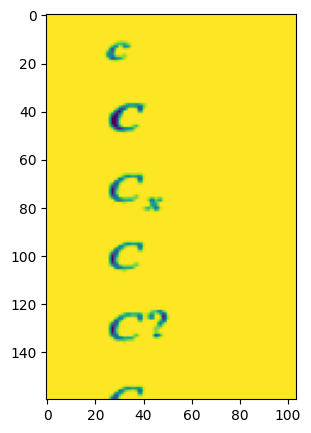

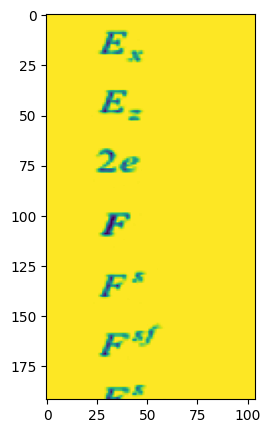

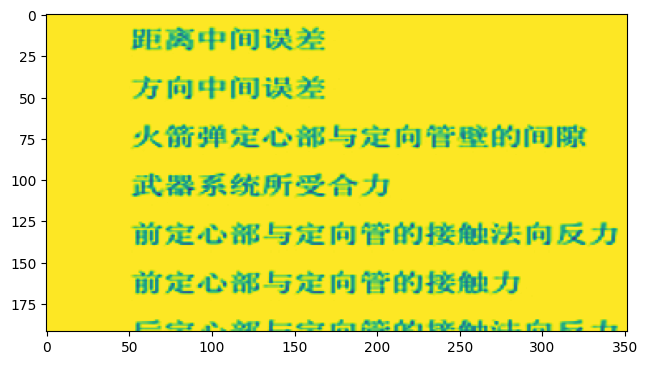

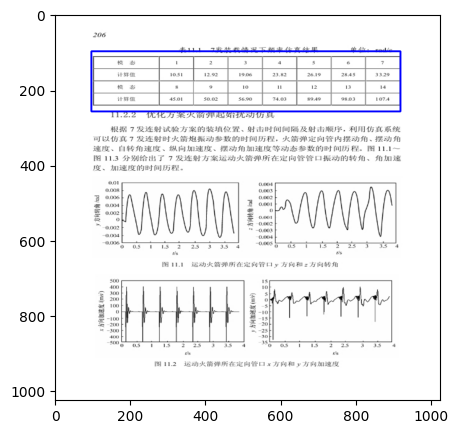

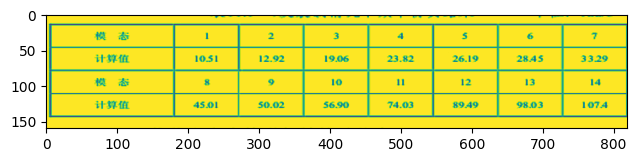

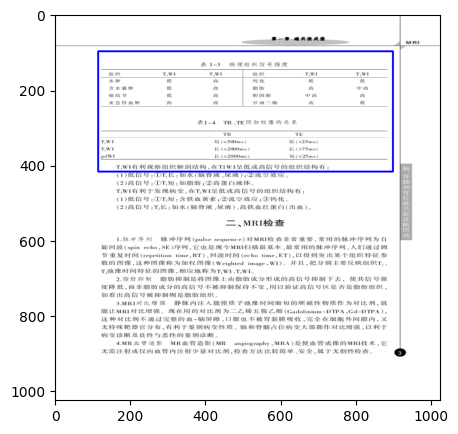

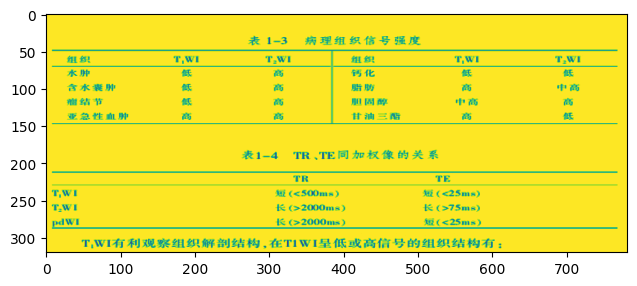

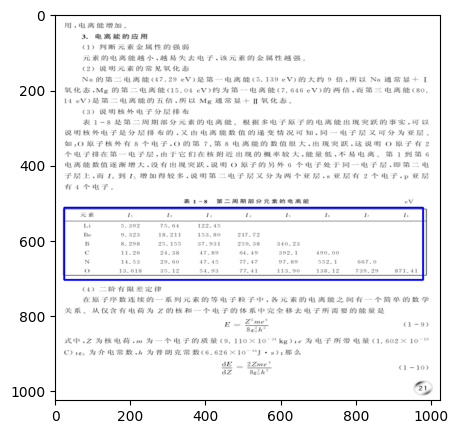

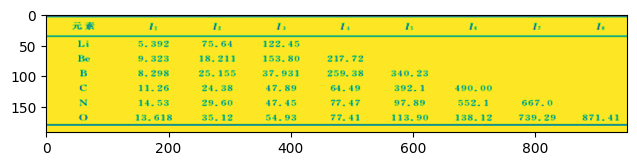

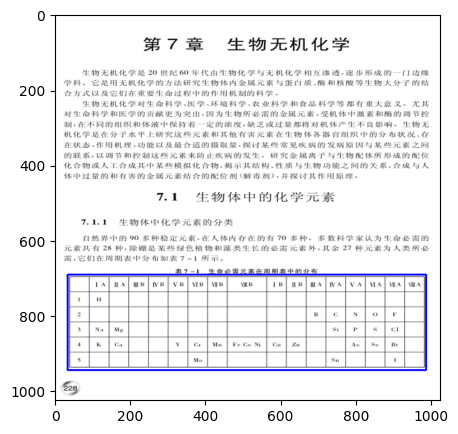

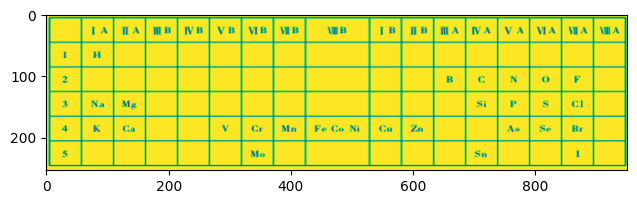

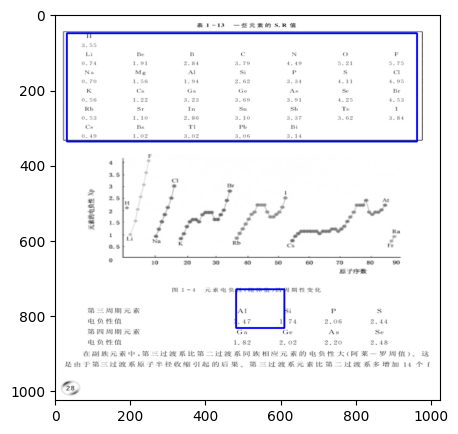

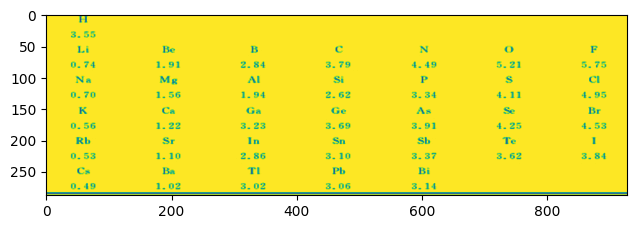

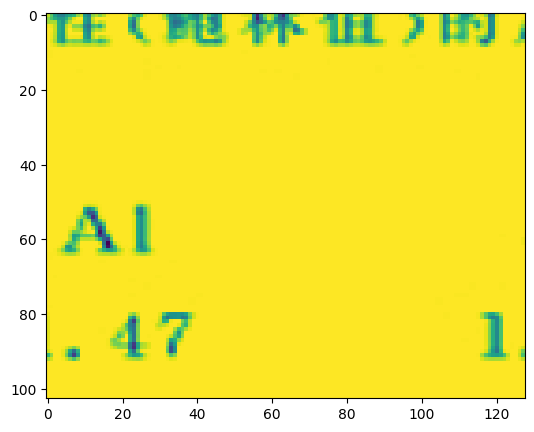

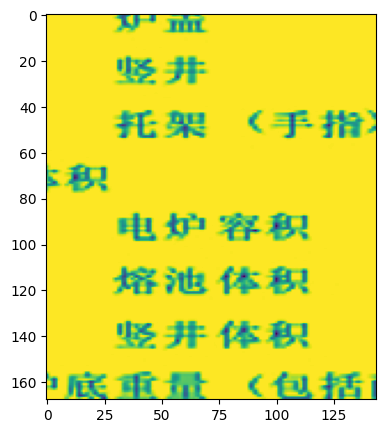

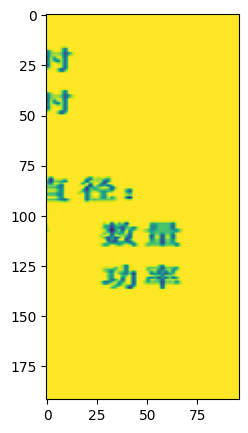

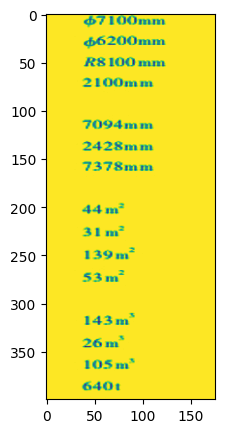

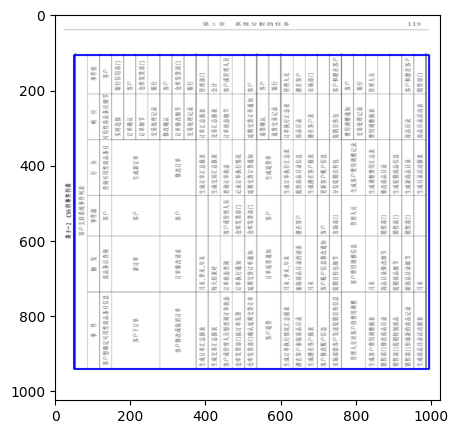

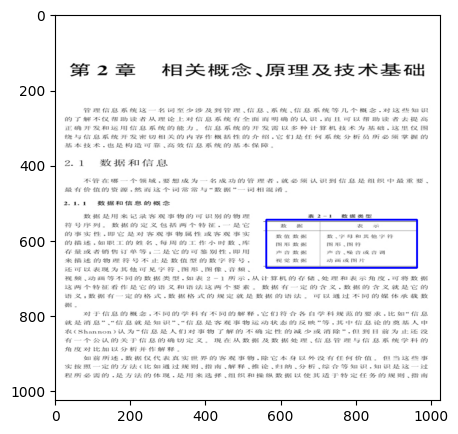

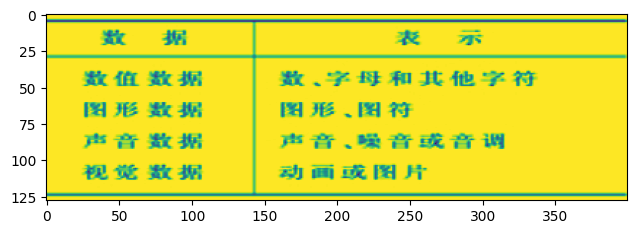

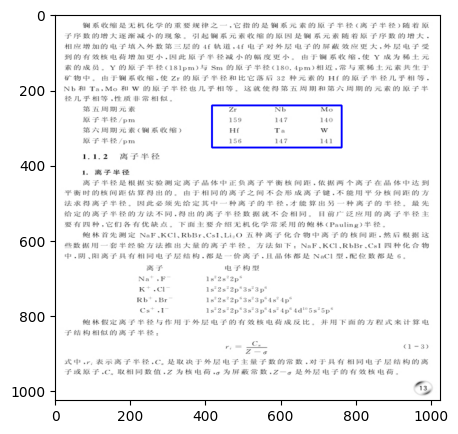

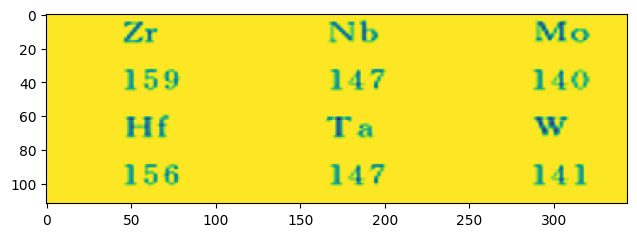

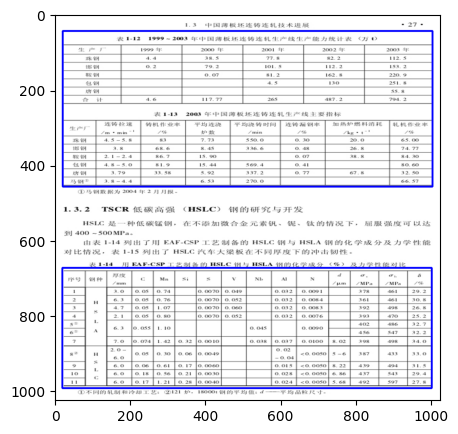

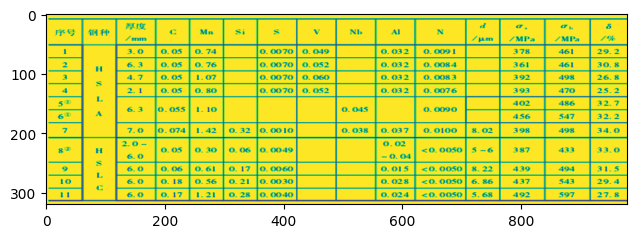

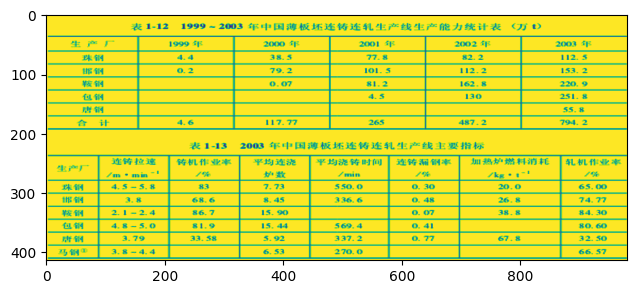

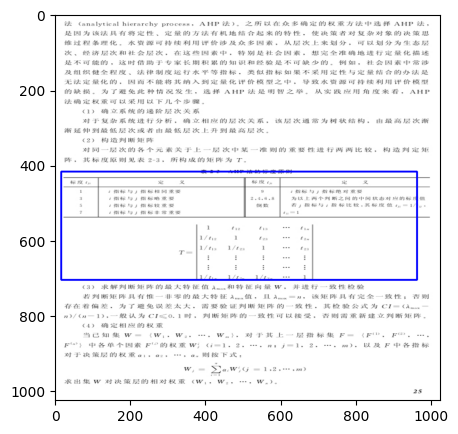

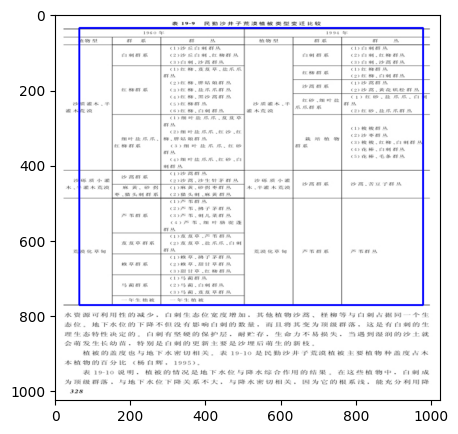

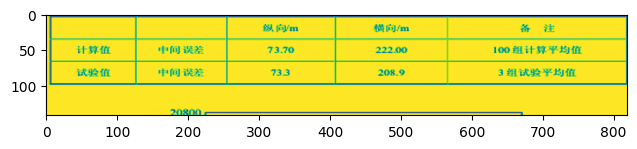

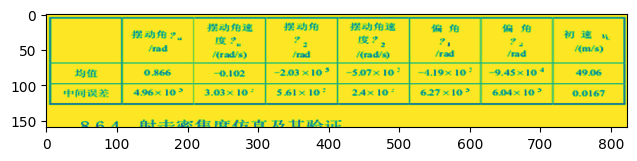

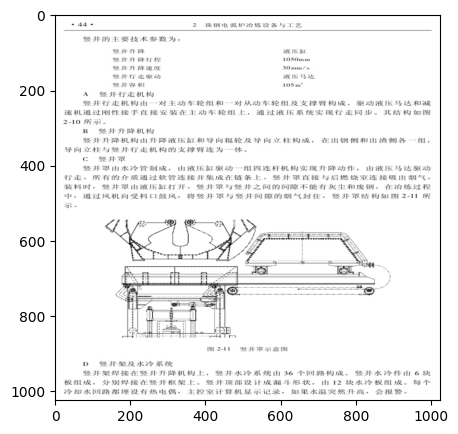

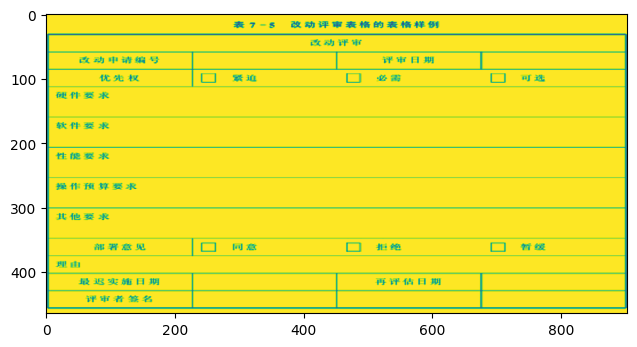

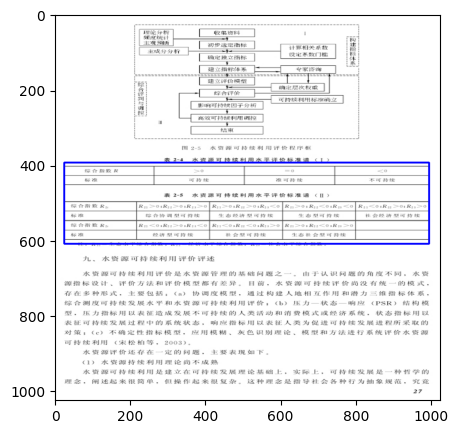

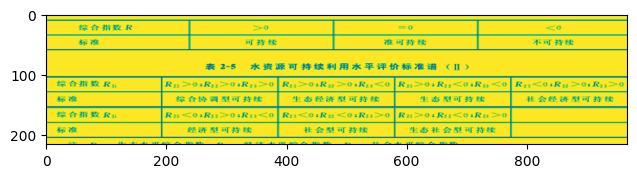

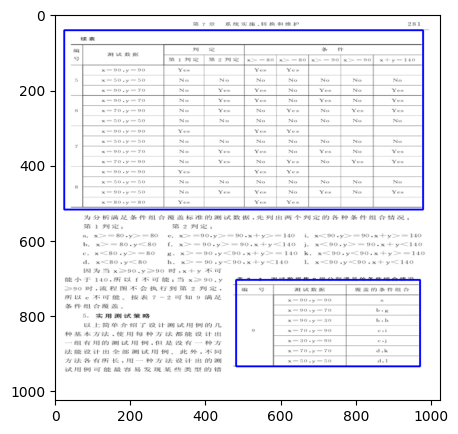

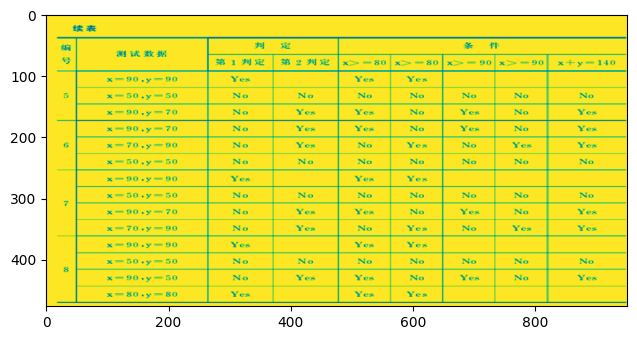

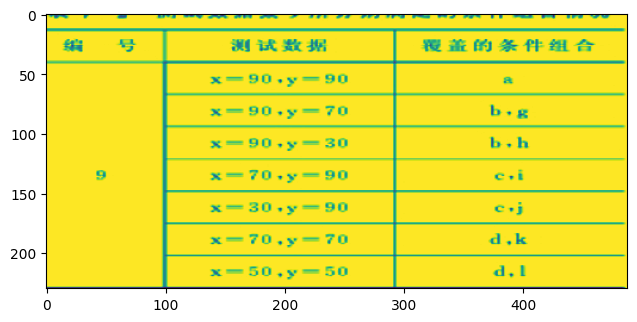

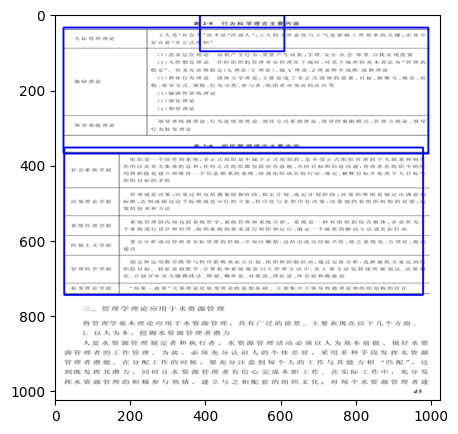

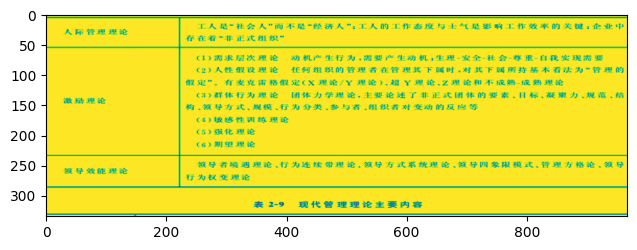

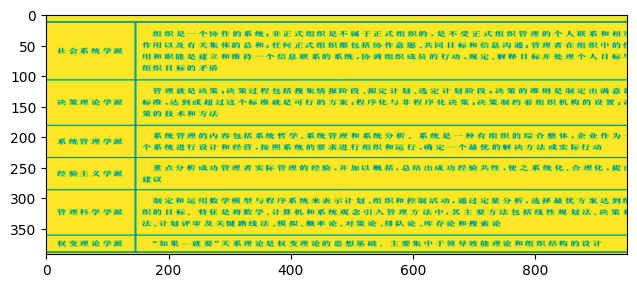

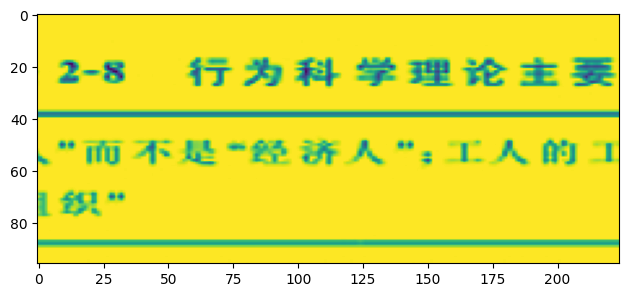

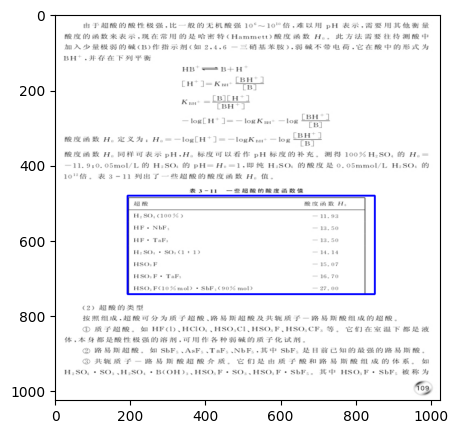

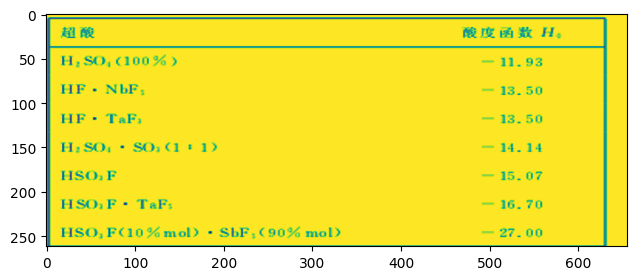

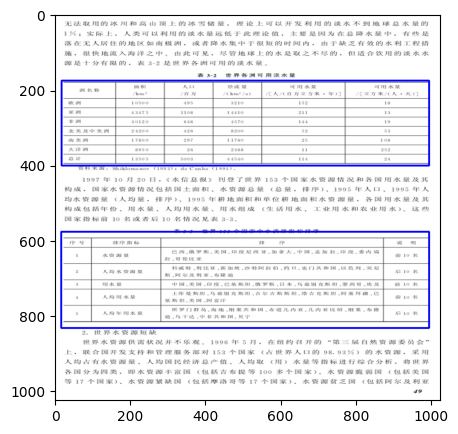

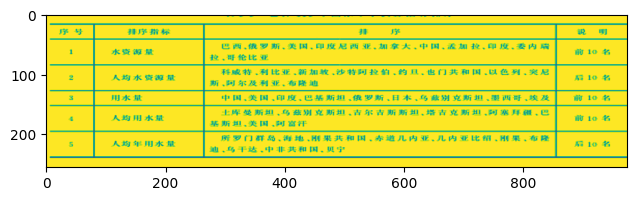

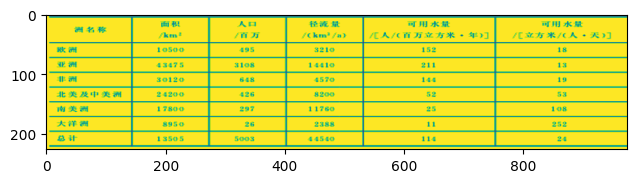

In [70]:
rows_pred = []
for filename in df['Filename'].unique():
    image_path = f'{TEST_IMAGES}/ICDAR/{filename}.jpg'
    orig_img = Image.open(image_path)
    height, width = orig_img.size
    bboxes = getPredictedBoundingBoxes(image_path)
    predict(image_path)
    if bboxes == "No Table detected":
        continue
    for bbox in bboxes:
        xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox
        rows_pred.append([filename, height, width, xmin_pred, ymin_pred, xmax_pred, ymax_pred])

df_pred = pd.DataFrame(rows_pred, columns=['Filename', 'height_orig', 'width_orig' ,'xmin_pred', 'ymin_pred', 'xmax_pred', 'ymax_pred'])
df_pred.head()

In [71]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     54 non-null     object
 1   height_orig  54 non-null     int64 
 2   width_orig   54 non-null     int64 
 3   xmin_pred    54 non-null     int64 
 4   ymin_pred    54 non-null     int64 
 5   xmax_pred    54 non-null     int64 
 6   ymax_pred    54 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 3.1+ KB


In [47]:
df_pred.head()

Filename  height_orig  width_orig  xmin_pred  ymin_pred  xmax_pred  \
0    4_152          576         912         50         42        960   
1    4_152          576         912         56        640        960   
2     3_60          469         627         96        224        896   
3     3_60          469         627         96        591        896   
4    3_107          469         627        115         48        915   

   ymax_pred  
0        352  
1        800  
2        576  
3       1003  
4        496

In [48]:
df.to_csv(f'{TEST_IMAGES}/ICDAR/ground_truth.csv', index=False)
df_pred.to_csv(f'{TEST_IMAGES}/ICDAR/predicted.csv', index=False)

In [72]:
def compute_iou(boxA, boxB):
    """Compute the Intersection over Union (IoU) of two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def compute_metrics_for_image(gt_boxes, pred_boxes, iou_threshold=0.5):
    """Compute TP, FP, and FN for a single image given its ground truth and predicted boxes."""
    TP = 0
    FP = 0
    FN = 0
    matched = []

    for pred_box in pred_boxes:
        has_match = False
        for idx, gt_box in enumerate(gt_boxes):
            if compute_iou(pred_box, gt_box) > iou_threshold and idx not in matched:
                TP += 1
                matched.append(idx)
                has_match = True
                break

        if not has_match:
            FP += 1

    FN = len(gt_boxes) - len(matched)

    return TP, FP, FN

def compute_metrics_for_image_v2(gt_boxes, pred_boxes, iou_threshold=0.5):
    TP = 0
    FP = 0
    matched_gt_indices = []

    for pred_box in pred_boxes:
        max_iou = 0
        matched_gt_idx = -1
        for idx, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box, gt_box)
            if iou > max_iou and idx not in matched_gt_indices:
                max_iou = iou
                matched_gt_idx = idx

        if max_iou > iou_threshold:
            TP += 1
            matched_gt_indices.append(matched_gt_idx)
        else:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt_indices)

    return TP, FP, FN


In [73]:
# Define a function to rescale bounding boxes
def rescale_bbox(row, original_width, original_height, resized_width=1024, resized_height=1024):
    width_scale = original_width / resized_width
    height_scale = original_height / resized_height

    xmin = int(row['xmin_pred'] * width_scale)
    ymin = int(row['ymin_pred'] * height_scale)
    xmax = int(row['xmax_pred'] * width_scale)
    ymax = int(row['ymax_pred'] * height_scale)

    return pd.Series([xmin, ymin, xmax, ymax], index=['xmin_rescaled', 'ymin_rescaled', 'xmax_rescaled', 'ymax_rescaled'])


In [74]:
df_predicted = df_pred.copy()
# Apply the rescaling function to the updated predicted dataframe using the correct column names
df_predicted[['xmin_rescaled', 'ymin_rescaled', 'xmax_rescaled', 'ymax_rescaled']] = df_predicted.apply(lambda row: rescale_bbox(row, row['width_orig'], row['height_orig']), axis=1)

df_predicted.head()


Filename  height_orig  width_orig  xmin_pred  ymin_pred  xmax_pred  \
0    4_152          576         912         50         42        960   
1    4_152          576         912         56        640        960   
2     3_60          469         627         96        224        896   
3     3_60          469         627         96        591        896   
4    3_107          469         627        115         48        915   

   ymax_pred  xmin_rescaled  ymin_rescaled  xmax_rescaled  ymax_rescaled  
0        352             44             23            855            198  
1        800             49            360            855            450  
2        576             58            102            548            263  
3       1003             58            270            548            459  
4        496             70             21            560            227

In [75]:
df.head()

Filename  xmin_orig  ymin_orig  xmax_orig  ymax_orig
0    4_152         33         69        539        257
1    4_152         32        570        539        703
2     3_60         47        143        412        345
3     3_60         47        383        412        615
4    3_107         54        331        418        611

In [76]:

TPs, FPs, FNs = [], [], []
for image_filename in df['Filename'].unique():
    gt_boxes = df[df['Filename'] == image_filename][['xmin_orig', 'ymin_orig', 'xmax_orig', 'ymax_orig']].values.tolist()
    pred_boxes = df_predicted[df_predicted['Filename'] == image_filename][['xmin_rescaled', 'ymin_rescaled', 'xmax_rescaled', 'ymax_rescaled']].values.tolist()
    TP, FP, FN = compute_metrics_for_image_v2(gt_boxes, pred_boxes, 0.33)
    TPs.append(TP)
    FPs.append(FP)
    FNs.append(FN)

# Compute precision and recall
total_TP, total_FP, total_FN = sum(TPs), sum(FPs), sum(FNs)
precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0
# Compute the F1 score using the formula
f1_score = (2 * precision * recall) / (precision+ recall) if (precision + recall) != 0 else 0

f1_score


precision, recall, f1_score

(0.25925925925925924, 0.28, 0.2692307692307692)